In [1]:
import os
import pandas as pd
from contextlib import nullcontext
import matplotlib.pyplot as plt

import numpy as np
import torch

from model import GPTConfig, GPT
from data import data_columns, get_data_for_eval, decode_data, encode_data, get_ticker_data
from stockdata import StockData


In [2]:
ticker = 'SPY'
currentDir = '.'

In [3]:
# -----------------------------------------------------------------------------
# configs
# I/O
out_dir = 'out'

# system
device = 'mps' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler

# various inits, derived attributes, I/O setup
seed_offset = 0

torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)


In [25]:
# model init
model_args = dict()

ckpt_path = os.path.join(out_dir, 'ckpt.pt')
if not os.path.exists(ckpt_path):
    print("can't find checkpoint file: " + ckpt_path)
    exit(1)

checkpoint = torch.load(ckpt_path, map_location=device)
checkpoint_model_args = checkpoint['model_args']
# force these config attributes to be equal otherwise we can't even resume training
# the rest of the attributes (e.g. dropout) can stay as desired from command line
for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
    model_args[k] = checkpoint_model_args[k]
# create the model
gptconf = GPTConfig(**model_args)
model = GPT(gptconf)
state_dict = checkpoint['model']
# fix the keys of the state dictionary :(
# honestly no idea how checkpoints sometimes get this prefix, have to debug more
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)

model.to(device)
model.eval()
checkpoint = None # free up memory


number of parameters: 0.80M


In [26]:
print(gptconf)

GPTConfig(block_size=512, vocab_size=94, n_layer=4, n_head=32, n_embd=128, dropout=0.0, bias=False)


In [6]:
# refresh the most recent data
get_ticker_data("^VIX", f"{currentDir}/data", False)
get_ticker_data("^TNX", f"{currentDir}/data", False)
get_ticker_data(ticker, f"{currentDir}/data", False)

True

Predicting for dates > 2024-05-06
=== close mean 0.15499999999999997 volume mean 0.05 vix 12.5 ===
=== open mean 0.28124999999999994 high mean 0.8637500000000001 low mean -0.4625 ===

=== ground truth ===
=== close mean 0.125 volume mean -0.1875 vix mean 10.0 ===
=== open mean -0.1875 high mean 0.4375 low mean -0.4375 ===


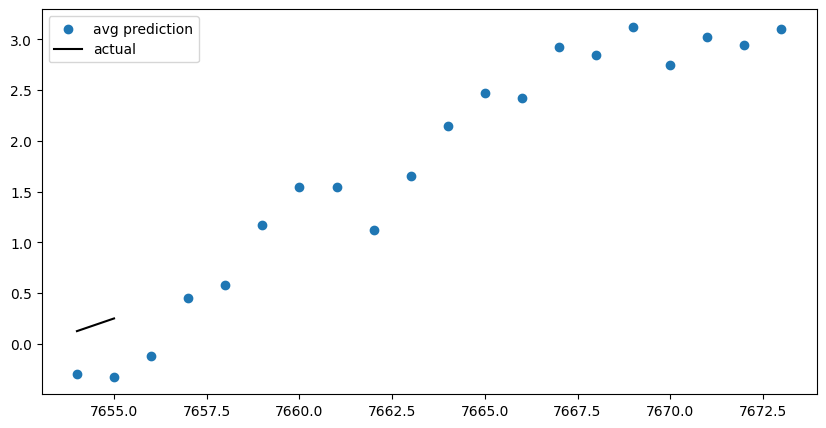

In [79]:
plt.figure(figsize=(10, 5)) 
std_columns = ['close_std', 'open_std', 'high_std', 'low_std', 'volume_std', 'vix']
cutoff_date = "2024-05-06"
iter_count = 5
predict_days = 20
all_data_df = get_data_for_eval(ticker, data_dir=f"{currentDir}/data")
context_df = all_data_df[all_data_df.Date <= cutoff_date]
context = encode_data(context_df)

preds = []
for i in range(iter_count):
    y = model.generate(context.to(device), max_new_tokens=predict_days*len(data_columns), temperature=0.2)
    pred = decode_data(y) # pred includes all the context
    new_pred = pred[-predict_days:].copy()
    new_pred.loc[:, 'close_std'] = (new_pred.close_bucket - StockData.CLOSE_LABELS.min()).map(lambda x: StockData.BIN_VALUES[x])
    new_pred.loc[:, 'open_std'] = (new_pred.open_bucket - StockData.OPEN_LABELS.min()).map(lambda x: StockData.BIN_VALUES[x])
    new_pred.loc[:, 'high_std'] = (new_pred.high_bucket - StockData.HIGH_LABELS.min()).map(lambda x: StockData.BIN_VALUES[x])
    new_pred.loc[:, 'low_std'] = (new_pred.low_bucket - StockData.LOW_LABELS.min()).map(lambda x: StockData.BIN_VALUES[x])
    new_pred.loc[:, 'volume_std'] = (new_pred.volume_bucket  - StockData.VOLUME_LABELS.min()).map(lambda x: StockData.BIN_VALUES[x])
    new_pred.loc[:, 'vix'] = (new_pred.vix_bucket  - StockData.VIX_LABELS.min()).map(lambda x: StockData.VIX_BINS[x])
    # plt.plot(new_pred.close_std.cumsum(), label='prediction') 

    preds.append(new_pred)

new_pred = preds[0]
for i in range(1, iter_count):
    new_pred += preds[i]
new_pred /= iter_count


print(f"Predicting for dates > {context_df.iloc[-1].Date}")
print(f"=== close mean {new_pred.close_std.mean()} volume mean {new_pred.volume_std.mean()} vix {new_pred.vix.mean()+2.5} ===")
print(f"=== open mean {new_pred.open_std.mean()} high mean {new_pred.high_std.mean()} low mean {new_pred.low_std.mean()} ===")
# print(new_pred[std_columns])
print("")
plt.scatter(y=new_pred.close_std.cumsum(), x=new_pred.index, label='avg prediction') 

# print out the ground truth
if len(all_data_df) > len(context_df):
    print("=== ground truth ===")
    ground_truth = all_data_df.iloc[len(context_df):len(pred)].copy()
    ground_truth.loc[:, 'close_std'] = (ground_truth.close_bucket - StockData.CLOSE_LABELS.min()).map(lambda x: StockData.BIN_VALUES[x])
    ground_truth.loc[:, 'open_std'] = (ground_truth.open_bucket - StockData.OPEN_LABELS.min()).map(lambda x: StockData.BIN_VALUES[x])
    ground_truth.loc[:, 'high_std'] = (ground_truth.high_bucket - StockData.HIGH_LABELS.min()).map(lambda x: StockData.BIN_VALUES[x])
    ground_truth.loc[:, 'low_std'] = (ground_truth.low_bucket - StockData.LOW_LABELS.min()).map(lambda x: StockData.BIN_VALUES[x])
    ground_truth.loc[:, 'volume_std'] = (ground_truth.volume_bucket  - StockData.VOLUME_LABELS.min()).map(lambda x: StockData.BIN_VALUES[x])
    ground_truth.loc[:, 'vix'] = (ground_truth.vix_bucket  - StockData.VIX_LABELS.min()).map(lambda x: StockData.VIX_BINS[x])
    print(f"=== close mean {ground_truth.close_std.mean()} volume mean {ground_truth.volume_std.mean()} vix mean {ground_truth.vix.mean()} ===")
    print(f"=== open mean {ground_truth.open_std.mean()} high mean {ground_truth.high_std.mean()} low mean {ground_truth.low_std.mean()} ===")
    # print(ground_truth[std_columns])
    plt.plot(ground_truth.close_std.cumsum(), label='actual', color='black') 

plt.legend()  # Adds a legend to distinguish the lines
plt.show()  # Displays the plot